In [2]:
import tensorflow as tf
import os
import random
import numpy as np

In [3]:
SEED = 123456
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

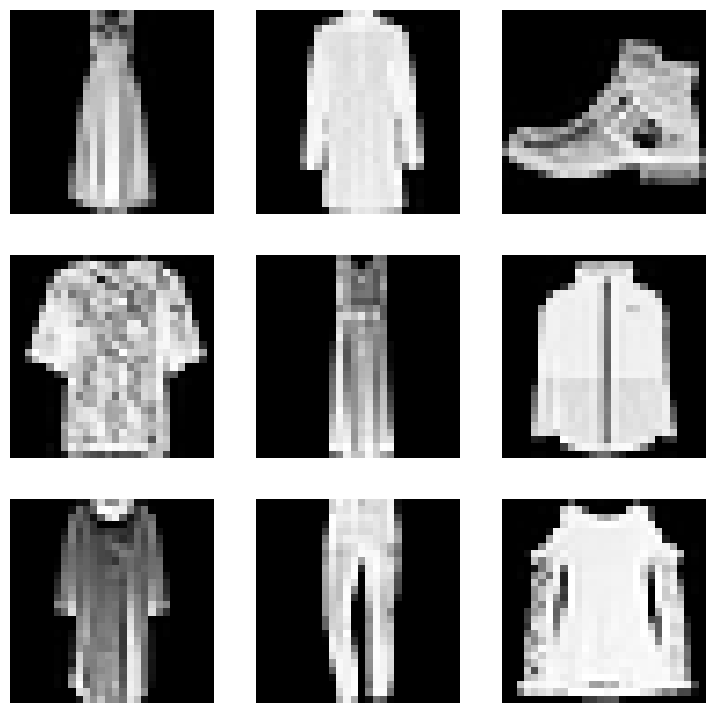

In [13]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(9,9))

rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[rndSamples[i]], cmap='Greys_r')
    plt.axis('off')

plt.show()

In [14]:
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype('float32') / 255

In [15]:
import keras
from keras.layers import Layer

class SamplingLayer(Layer):
    def call(self, inputs):
        zMean, zLogVar = inputs
        batch = tf.shape(zMean)[0]
        dim = tf.shape(zMean)[1]
        epsilon = keras.backend.random_normal(shape=(batch, dim))
        return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [18]:
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense

def buildEncoder(latentDim, encoderInputs):
    l1 = Sequential([
        Conv2D(128, 3, activation='relu', strides=2, padding='same'),
        Conv2D(64, 3, activation='relu', strides=2, padding='same'),
        Flatten(),
        Dense(256, activation='relu')
    ])

    x = l1(encoderInputs)

    zMean = Dense(latentDim, name='z_mean')(x)
    zLogVar = Dense(latentDim, name='z_log_var')(x)
    z = SamplingLayer()([zMean, zLogVar])

    return Model(encoderInputs, [zMean, zLogVar, z], name='encoder')

encoderInputs = Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 256)                  878144    ['input_3[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['sequential_2[0][0]']        
                                                                                                  
 z_log_var (Dense)           (None, 2)                    514       ['sequential_2[0][0]']        
                                                                                            

In [19]:
from keras.layers import Reshape, Conv2DTranspose

def buildeDecoder(latentInputs):

    l1 = Sequential([
        Dense(7*7*64, activation='relu', input_shape=(latentInputs.shape[1], )),
        Reshape((7,7,64)),
        Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
        Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
        Conv2DTranspose(1, 3, activation='sigmoid', padding='same')
    ])

    return Model(latentInputs, l1(latentInputs), name='decoder')

latentInputs = Input(shape=(2,))
decoder = buildeDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157633 (615.75 KB)
Trainable params: 157633 (615.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
from keras.losses import binary_crossentropy

def reconstructionLoss(data, reconstructed):
    return tf.reduce_mean(
        tf.reduce_sum(
            binary_crossentropy(data, reconstructed),
            axis=(1,2)
        )
    )

In [21]:
def klDivergenceLoss(zMean, zLogVar):
    return tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
            axis=1
        )
    )

In [22]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = klDivergenceLoss(zMean, zLogVar)
    klWeight = 3.0
    return loss1, loss2, loss1 + klWeight * loss2

In [24]:
from keras.metrics import Mean

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.totalLossTracker = Mean(name='total_loss')
        self.ceLossTracker = Mean(name='ce_loss')
        self.klLossTracker = Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.totalLossTracker,
            self.ceLossTracker,
            self.klLossTracker
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            zMean, zLogVar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
        
        grads = tape.gradient(totalLoss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)

        return {
            'total_loss': self.totalLossTracker.result(),
            'ce_loss': self.ceLossTracker.result(),
            'kl_loss': self.klLossTracker.result()
        }

In [25]:
from keras.optimizers import Adam

vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32


2024-01-25 16:40:34.558416: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 219520000 exceeds 10% of free system memory.


255/547 [============>.................] - ETA: 1:26 - total_loss: 341.1864 - ce_loss: 332.1887 - kl_loss: 2.9992

KeyboardInterrupt: 